# Connecting Spectra to Mocks

The purpose of this notebook is to demonstrate how to generate spectra and apply target selection cuts for various mock catalogs and target types.  Here we generate spectra for targets in a single healpixel with no constraints on the target density (relative to the expected target density) or contaminants.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from desiutil.log import get_logger, DEBUG
log = get_logger()

In [3]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

In [4]:
%matplotlib inline

## Exploring the mocks

Let's start by visualizing the default set of mocks currently being used in the DESI Data Challenges.

#### Dark-time targets: QSOs (tracer & Lya), LRGs, and ELGs

In [5]:
from desitarget.mock.mockmaker import QSOMaker, LYAMaker, LRGMaker, ELGMaker

INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16!
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/QSO.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 3739643 QSOs in 1269 healpixel(s).


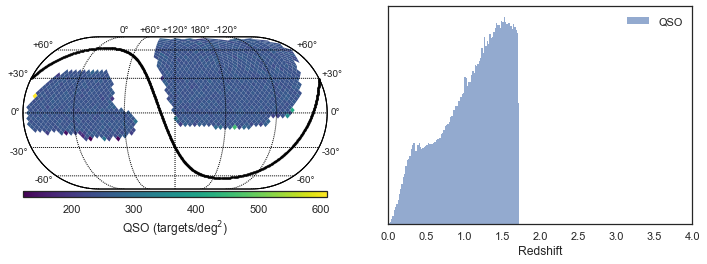

INFO:mockmaker.py:1099:readmock: Reading the whole DESI footprint with nside = 16!
INFO:mockmaker.py:1110:readmock: Reading /Users/ioannis/work/desi/mocks/lya_forest/v2.0.2/master.fits
INFO:mockmaker.py:1123:readmock: Assigning healpix pixels with nside = 16
INFO:mockmaker.py:1135:readmock: Trimmed to 2209348 LYAs in 1269 healpixel(s).


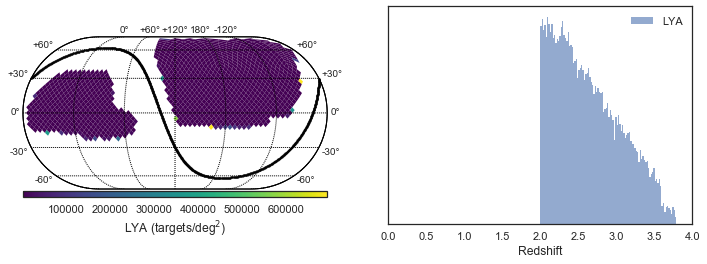

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/lrg_templates_v2.0.fits
INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16!
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/LRG.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 14230581 LRGs in 1269 healpixel(s).


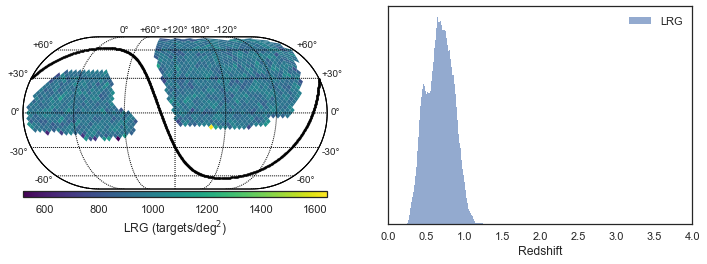

INFO:io.py:1025:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.5/elg_templates_v2.0.fits
INFO:mockmaker.py:627:readmock: Reading the whole DESI footprint with nside = 16!
INFO:mockmaker.py:638:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.7_2LPT/ELG.fits
INFO:mockmaker.py:643:readmock: Assigning healpix pixels with nside = 16.
INFO:mockmaker.py:655:readmock: Trimmed to 72019558 ELGs in 1269 healpixel(s).


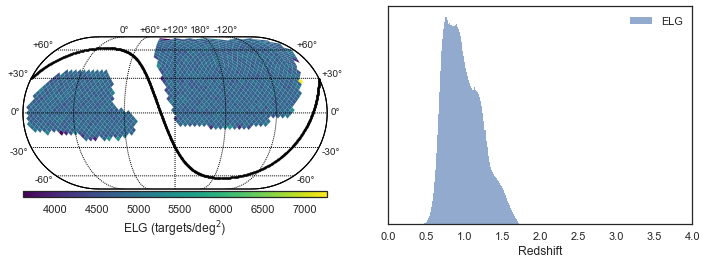

In [7]:
for Maker in (QSOMaker, LYAMaker, LRGMaker, ELGMaker):
    M = Maker()
    data = M.read()
    M.qamock_sky(data)

#### Specify the (required) path to the dust maps and the desired healpixel.

In [ ]:
dust_dir = '/Users/ioannis/research/data/sfd_dustmaps/maps'

In [ ]:
healpixel = 26030
nside = 64

In [ ]:
seed = 555
rand = np.random.RandomState(seed)

#### Define a couple wrapper routines we will use below several times.

In [ ]:
def plot_subset(wave, flux, truth, nplot=16, ncol=4, these=None, 
                xlim=None, loc='right', targname='', objtype=''):
    """Plot a random sampling of spectra."""
    
    nspec, npix = flux.shape
    if nspec < nplot:
        nplot = nspec
    
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'
    
    if these is None:
        these = rand.choice(nspec, nplot, replace=False)
        these = np.sort(these)
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(truth['TEFF'][indx]), ha=ha,
                 va='top', transform=thisax.transAxes, fontsize=13)
        else:
            thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), ha=ha, 
                 va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)

In [ ]:
def demo_mockmaker(Maker, seed=None, nrand=16, loc='right'):

    TARGET = Maker(seed=seed)
    
    log.info('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)
    
    log.info('Generating {} random spectra.'.format(nrand))
    indx = rand.choice(len(tdata['RA']), np.min( (nrand, len(tdata['RA'])) ) )
    tflux, twave, tmeta, ttargets, ttruth = TARGET.make_spectra(tdata, indx=indx)
    
    log.info('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)
    
    plot_subset(twave, tflux, ttruth, loc=loc, targname=tdata['TARGET_NAME'], 
                objtype=TARGET.objtype)

### Tracer QSOs

Both tracer and Lya QSOs contain an underlying QSO spectrum but the Lya QSOs (which we demonstrate below) also include the Lya forest from the latest CoLoRe skewer mocks.

In [ ]:
from desitarget.mock.mockmaker import QSOMaker

In [ ]:
QSO = QSOMaker(seed=seed)

#### The various `read` methods return a dictionary with target-specific quantities.

In [ ]:
data = QSO.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

In [ ]:
for key in sorted(list(data.keys())):
    print('{:>20}, {:3d}, {}'.format(key, len(data[key]), type(data[key])))

#### Now we can generate the spectra as well as the targeting catalogs (`targets`) and corresponding truth table.

In [ ]:
%time flux, wave, meta, targets, truth = QSO.make_spectra(data)

In [ ]:
print(flux.shape, wave.shape)

#### The truth (and meta) catalog contains all the input, known target properties.

In [ ]:
truth[:2]

In [ ]:
meta[:2]

#### Let's plot some example spectra.

In [ ]:
plot_subset(wave, flux, truth, targname='QSO')

#### Select DESI targets, after which point the targets catalog should look just like an imaging targeting catalog.

In other words, `targets` includes noisy photometry as well as targeting information.

In [ ]:
QSO.select_targets(targets, truth)

In [ ]:
targets[:2]

In [ ]:
keep = targets['DESI_TARGET'] != 0
log.info('Identified {} / {} DESI QSO targets.'.format(np.sum(keep), len(targets)))

### Generating QSO spectra with cosmological Lya skewers proceeds along similar lines.

Note that the current set of Lya mocks (based on CoLoRe) have only 5 A wavelength resolution, so the Lya forest is not very obvious in the spectra below.

In [ ]:
from desitarget.mock.mockmaker import LYAMaker

In [ ]:
LYA = LYAMaker(seed=seed)

In [ ]:
lyadata = LYA.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

In [ ]:
%time lyaflux, lyawave, lyameta, lyatargets, lyatruth = LYA.make_spectra(lyadata)

In [ ]:
plot_subset(lyawave, lyaflux, lyatruth, xlim=(3500, 5500), targname='LYA')

### Demonstrate the other extragalactic target classes: LRG, ELG, and BGS.

#### LRGs

In [ ]:
from desitarget.mock.mockmaker import LRGMaker

In [ ]:
%time demo_mockmaker(LRGMaker, seed=seed, loc='left')

#### ELGs

In [ ]:
from desitarget.mock.mockmaker import ELGMaker

In [ ]:
%time demo_mockmaker(ELGMaker, seed=seed, loc='left')

#### BGS

In [ ]:
from desitarget.mock.mockmaker import BGSMaker

In [ ]:
%time demo_mockmaker(BGSMaker, seed=seed)

### Next, demonstrate how to generate spectra of stars...

#### MWS_MAIN

In [ ]:
from desitarget.mock.mockmaker import MWS_MAINMaker

In [ ]:
%time demo_mockmaker(MWS_MAINMaker, seed=seed, loc='left')

#### MWS_NEARBY

In [ ]:
from desitarget.mock.mockmaker import MWS_NEARBYMaker

In [ ]:
%time demo_mockmaker(MWS_NEARBYMaker, seed=seed, loc='left')

#### White dwarfs (WDs)

In [ ]:
from desitarget.mock.mockmaker import WDMaker

In [ ]:
%time demo_mockmaker(WDMaker, seed=seed, loc='right')

### Finally demonstrate how to generate (empyt) SKY spectra.

In [ ]:
from desitarget.mock.mockmaker import SKYMaker

In [ ]:
SKY = SKYMaker(seed=seed)

In [ ]:
skydata = SKY.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

In [ ]:
skyflux, skywave, skymeta, skytargets, skytruth = SKY.make_spectra(skydata)

In [ ]:
SKY.select_targets(skytargets, skytruth)